# Analysis of Time Delay Embedding

The code and the analysis is mostly based based on the following papers:

* Abarbanel, H. D., Brown, R., Sidorowich, J. J., & Tsimring, L. S. (1993). The analysis of observed chaotic data in physical systems. Reviews of modern physics, 65(4), 1331.
* Gilpin, W. (2020). Deep reconstruction of strange attractors from time series. Advances in neural information processing systems, 33, 204-216.
* van Kekem, D. L., & Sterk, A. E. (2019). Symmetries in the Lorenz-96 model. International Journal of Bifurcation and Chaos, 29(01), 1950008.

### Most of the analysis will be done for 2 systems- Lorenz system(xl,yl,zl) and Henon map(xh,yh) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

Generating Lorenz Attractor Points

In [2]:
# Parameters of the model
s=10.0
b=8.0/3.0
gamma=28.0

# Function to define the Lorenz model
def lorenz(r,t):
    x=r[0]
    y=r[1]
    z=r[2]
    fx=10*(y-x)
    fy=28*x-y-x*z
    fz=x*y-b*z
    return np.array([fx,fy,fz])

In [3]:
a=0
tf=200
Nl=20000
h=(tf-a)/Nl
tl=np.arange(a,tf,h)


xl=np.ones(Nl+1)
yl=np.ones(Nl+1)
zl=np.ones(Nl+1)
#initial condition
r=np.array([1.,1.,1.])
i=0
for t in tl:
    k1=h*lorenz(r,t)
    k2=h*lorenz(r+0.5*k1,t+0.5*h)
    k3=h*lorenz(r+0.5*k2,t+0.5*h)
    k4=h*lorenz(r+k3,t+h)
    r+= (k1+2*k2+2*k3+k4)/6
    xl[i]=r[0]
    yl[i]=r[1]
    zl[i]=r[2]
    i=i+1
xl,yl,zl=xl[5000:],yl[5000:],zl[5000:]
Nl=15000

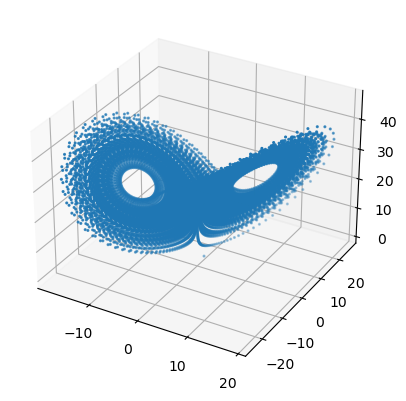

In [4]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(xl,yl,zl, s=1.5)
plt.show()

Generating Henon Attractor points

In [5]:
a=1.4
b=0.3
Nh=5000
xh=np.zeros(Nh)
yh=np.zeros(Nh)
def Henon(x,y):
    for i in range(Nh-1):
        x[i+1]=1-a*x[i]**2+y[i]
        y[i+1]=b*x[i]
    return x,y

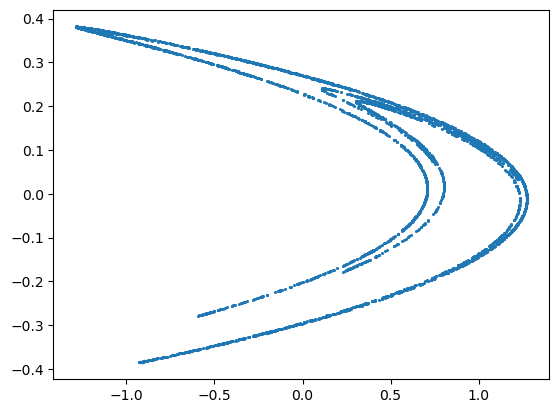

In [6]:
xh, yh=Henon(xh, yh)
xh,yh=xh[1000:],yh[1000:]
Nh=4000
plt.scatter(xh,yh,s=1.5 )

plt.show()

**Using Mutual Information(MI) as a tool to find optimal time delay**. Here, we use the minima for flows and the time when MI reaches 20% of the initial value for maps.

In [7]:
def shannon(x):
    if np.sum(x)!=0:
        x_norm=x/np.sum(x)
        x_norm=x_norm[np.nonzero(x_norm)]
        H=-np.sum(x_norm*np.log2(x_norm))
    else:
        H=1
    return(H)


The delay for Lorenz map is 0.17


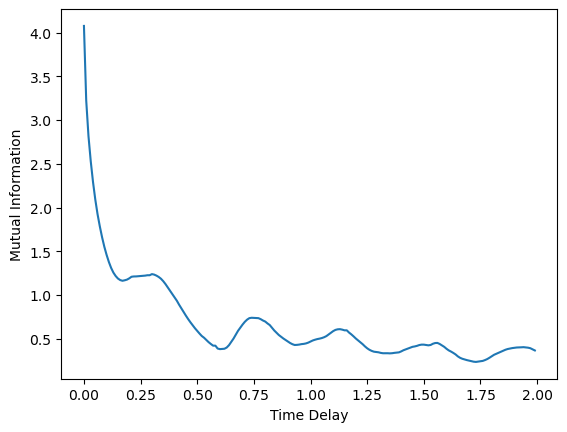

In [8]:
def MIlorenz(tau, x=xl,bins=20):
    tau=int(100*tau) #This line won't be used for Henon attractor 
    ami=0
    p_a=np.histogram(x, bins)[0] #convert x into a probability distribution
    xtau=np.roll(x,tau) #tau delayed version of x
    xtau=xtau[:-tau]
    p_b=np.histogram(xtau,bins)[0]
    x=x[:-tau] #slicing to get only tau elements

    p_ab=np.histogram2d(x,xtau,bins)[0]
    ami=shannon(p_a)+shannon(p_b)-shannon(p_ab)
    return ami

taum=tl[:200]
MIL=np.zeros(200)
for t in range(len(taum)):
    MIL[t]=MIlorenz(taum[t])
for t in range(len(taum)-1):    
  midiff=MIlorenz(taum[t+1])-MIlorenz(taum[t])
  midiff=midiff/h
  if midiff>0:
    
    Tlorenz=taum[t]
    break
print("The delay for Lorenz map is", Tlorenz)
plt.plot(taum,MIL)
plt.xlabel('Time Delay')
plt.ylabel('Mutual Information')
#plt.savefig('image.jpg')
plt.show()
Tlorenz=int(Tlorenz*100)

In [9]:
def MIhenon(tau,x=xh,bins=10):
    ami=0
    p_a=np.histogram(x, bins)[0]
    
    p_a=p_a #convert x into a probability distribution
    xtau=np.roll(x,tau) #tau delayed version of x
    xtau=xtau[:-tau]
    p_b=np.histogram(xtau,bins)[0]
    x=x[:-tau] #slicing to get only tau elements

    p_ab=np.histogram2d(x,xtau,bins)[0]
    ami=shannon(p_a)+shannon(p_b)-shannon(p_ab)

    return ami

taum=np.arange(40)
Minit=MIhenon(0)
for t in taum:
    
    if MIhenon(t)<=Minit/5:
      Thenon=t
      break
print("The time delay for Henon map can be", Thenon)

The time delay for Henon map can be 5


Thus, we get the time delay T for Lorenz model as Tlorenz=0.17 and T for Henon map as Thenon=4 \\
**Choosing the embedding dimension through FNN method**

In [10]:
rt=20
fnnhenon=np.ones(5) #taking 5 as max dimensions
for dim in range(1,6):
  col=1000-dim
  mhenon=np.zeros((dim,col))
  for i in range(col):
    mhenon[:,i]=np.array([xh[i+j] for j in range(dim)])
    dist=np.linalg.norm(mhenon-mhenon[:,i].reshape((dim,1)), axis=0)
    mindist=20000
    for k in range(col):
      if k==i:
        continue
      else:
        if dist[k]<mindist:
          min=k
          mindist=dist[k]
    if np.abs((xh[i+(dim+1)]-xh[min+(dim+1)])/mindist)>rt:
      fnnhenon[dim-1]+=1
  fnnhenon[dim-1]=fnnhenon[dim-1]/(col)*100

In [11]:
#~6s
fnnlorenz=np.zeros(5) #taking 5 as max dimensions
for dim in range(1,6):
  col=2000-dim*Tlorenz
  mlorenz=np.zeros((dim,col))
  for i in range(col):
    mlorenz[:,i]=np.array([xl[i+j*Tlorenz] for j in range(dim)])
    dist=np.linalg.norm(mlorenz-mlorenz[:,i].reshape((dim,1)), axis=0)
    mindist=20000
    for k in range(col):
      if k==i:
        continue
      else:
        if dist[k]<mindist:
          min=k
          mindist=dist[k]
    if np.abs((xl[i+(dim+1)*Tlorenz]-xl[min+(dim+1)*Tlorenz])/mindist)>rt:
      fnnlorenz[dim-1]+=1
  fnnlorenz[dim-1]=fnnlorenz[dim-1]/(col)*100

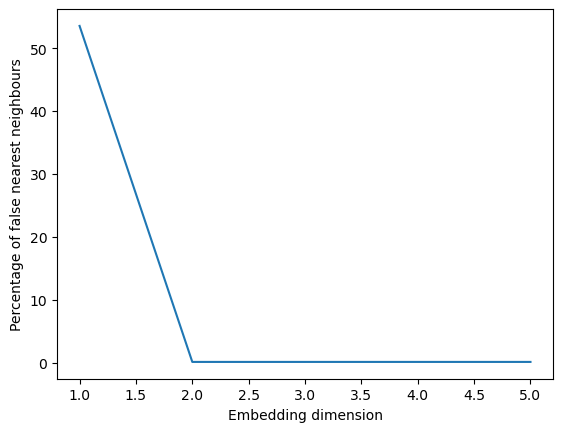

In [12]:
plt.plot(np.arange(1,6), fnnhenon)
plt.xlabel('Embedding dimension')
plt.ylabel('Percentage of false nearest neighbours')
#plt.savefig('Henonfnn.jpg')
plt.show()

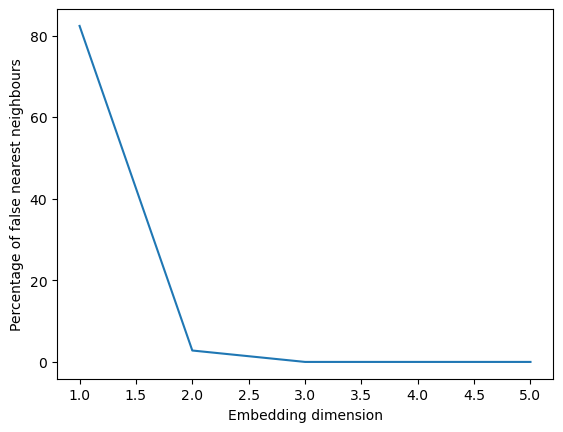

In [13]:
plt.plot(np.arange(1,6), fnnlorenz)
#print(fnnlorenz)
plt.xlabel('Embedding dimension')
plt.ylabel('Percentage of false nearest neighbours')
#plt.savefig('lorenzfnn.jpg')
plt.show()

Now, we try to reconstruct the attractors in 3 and 2 dimensions respectively, then we will try to see how close we are to the original attractor.

In [14]:
#original attractor
lorenzorig=np.zeros((Nl+1,3))
lorenzorig[:,0]=xl
lorenzorig[:,1]=yl
lorenzorig[:,2]=zl
#reconstructed attractor
lorenzrecon=np.zeros((15000-2*Tlorenz,3))
lorenzrecon[:,0]=xl[:-2*Tlorenz-1]
lorenzrecon[:,1]=xl[Tlorenz:-Tlorenz-1]
lorenzrecon[:,2]=xl[2*Tlorenz]

Thenon=1
henonorig=np.zeros((Nh,2),float)
henonorig[:,0]=xh
henonorig[:,1]=yh

henonrecon=np.zeros((Nh-Thenon,2))
henonrecon[:,0]=xh[:-Thenon]
henonrecon[:,1]=xh[Thenon:]

Meausures of closeness
1. Appearance of the reconstructed trajectory: We see how much the reconstruction looks like the original attractor. Not a very good measure.

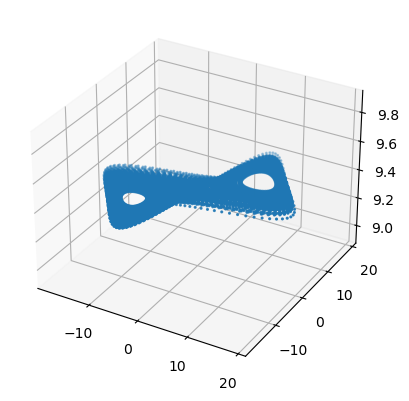

In [15]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(lorenzrecon[:,0],lorenzrecon[:,1],lorenzrecon[:,2], s=1.5)
#plt.savefig('Lorenzrecon.jpg')
plt.show()

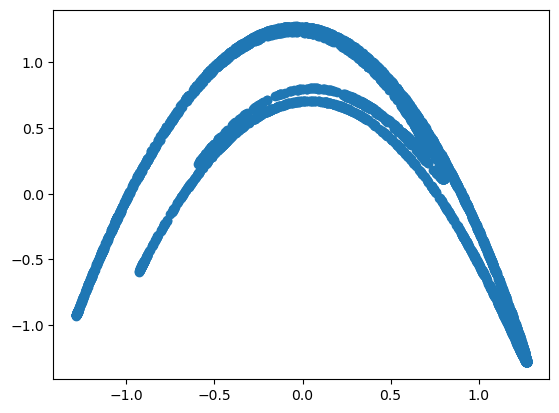

In [16]:
plt.scatter(henonrecon[:,0],henonrecon[:,1])
#plt.savefig('henonrecon.jpg')
plt.show()

This looks slightly close but it is pretty obvious that it is not the right way to check our embedding because of the vagueness of such a metric. Thus, we look for other ways.


---


**Issue**:Henon is giving a better embedding in this way if Thenon is taken to be 1 instead of the value found by this code(4&5) or values found by Abarbanel(somewhere around 5 or 6). Same issue found in pointwise comparison too.


---


2. Pointwise Comparison / Procrustes transform: We can only apply this transform as the original attractor and the final time delayed reconstruction are of the same number of dimensions. Procrustes transform applies translation, rotation, reflection to align the two sets of data we have, and then we find the $d_E$ dimensional Euclidean distance divided by the the number of points to normalise the distance.

In [17]:
from scipy.spatial import procrustes
print(np.shape(lorenzrecon))

lorenzorig=lorenzorig[:15000-2*Tlorenz,:]
#print(np.shape(lorenzorig))
mtl1,mtl2,eudl=procrustes(lorenzorig,lorenzrecon)
eudl=eudl/(len(lorenzorig))
print("Pointwise distance for Lorenz model reconstruction= ",eudl)

(14966, 3)
Pointwise distance for Lorenz model reconstruction=  2.915641271658622e-05


In [18]:
#print(np.shape(henonrecon))
henonorig=henonorig[:Nh-Thenon,:]
#print(np.shape(henonorig))
mth1,mth2,eudh=procrustes(henonorig,henonrecon)
eudh=eudh/(len(henonorig))
print("Pointwise distance for Henon map reconstruction= ",eudh)

Pointwise distance for Henon map reconstruction=  0.00011497067700920489


We see that the distance in both the cases is a small number as compared to the lengths of the attractors(~50 for Lorenz model and ~1 for Henon map). 
3. Local neighborhoods: We see that this is an algorithm that takes a lot of time, so we have taken very less number of points in this implementation.

In [19]:

lor=lorenzorig[-3000:,:]
lre=lorenzrecon[-3000:,:]
def kappa(k,y,yhat): 
  col=np.shape(y)[0]  #no of data points
  dim=np.shape(y)[1]  #no of dimensions
  kappa=np.zeros(col)
  for i in range(col):
    k_val=0
    dist=np.linalg.norm(y-(y[i,:].reshape(1,dim)), axis=1)
    distval=np.argsort(dist)[:k]
    dist2=np.linalg.norm(yhat-(yhat[i,:].reshape(1,dim)),axis=1)
    dist2val=np.argsort(dist2)[:k]
    kappa[i]=len(np.intersect1d(distval,dist2val))
  return np.mean(kappa)
#print(kappa(1700,lor,lre)) 
#print(kappa(3000,henonorig, henonrecon))


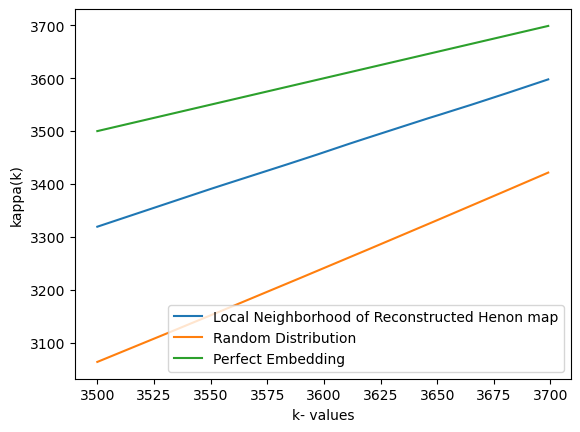

In [20]:
kvl=np.arange(3500,3700)
kpl=np.zeros(200)
for i in range(len(kpl)):
  kpl[i]=kappa(kvl[i],henonorig,henonrecon)
nhen=np.shape(henonorig)[0]
hypgeo=kvl*kvl/np.shape(henonorig)[0]
plt.plot(kvl,kpl, label="Local Neighborhood of Reconstructed Henon map")
plt.plot(kvl,hypgeo, label="Random Distribution")
plt.plot(kvl,kvl, label="Perfect Embedding")
plt.xlabel("k- values")
plt.ylabel("kappa(k)")
plt.legend()
# plt.savefig('Henonkappa.jpg')
plt.show()

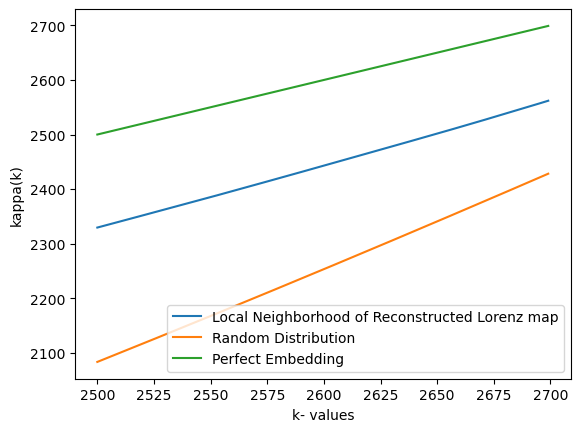

In [21]:
kvl=np.arange(2500,2700)
kpl=np.zeros(200)
for i in range(len(kpl)):
  kpl[i]=kappa(kvl[i],lor,lre)
nlor=np.shape(lor)[0]
hypgeo=kvl*kvl/np.shape(lor)[0]
plt.plot(kvl,kpl, label="Local Neighborhood of Reconstructed Lorenz map")
plt.plot(kvl,hypgeo, label="Random Distribution")
plt.plot(kvl,kvl, label="Perfect Embedding")
plt.xlabel("k- values")
plt.ylabel("kappa(k)")
plt.legend()
# plt.savefig('lorenzkappa.jpg')
plt.show()
#lornorm=np.sum(kpl)*2/(nlor(nlor+1))
#print(lornorm)
#print("random case", np.sum(2*hypgeo/(nlor*(nlor+1)))

4. Fractal Dimensions: Defined by the correlation dimension using the Grassberger-Procaccia paper. The implementation is not done very correctly and thus, the code is commented out.


In [22]:
'''def log_vals(min, max, fact):
  max_i = int(np.floor(np.log(max / min) / np.log(fact)))
  return np.array([min * (fact ** i) for i in range(max_i + 1)])
def frac_dim(orbit,fact=1.3):
  std=np.std(orbit)
  n=len(orbit)
  r_vals=log_vals(0.1*std,0.3*std,fact) 
  distances = np.zeros((n,n))
  r_matrix_base = np.zeros((n,n))
  for i in range(n):
    for j in range(i,n):
      distances[i][j] = np.linalg.norm(orbit[i]-orbit[j])
      r_matrix_base[i][j] = 1
  C_r = np.zeros(len(r_vals))
  i=0
  for r in r_vals:
    r_matrix = r_matrix_base*r
    heavi_matrix = np.heaviside( r_matrix - distances, 0)
    corr_sum = 2/(n*(n-1))*np.sum(heavi_matrix)
    C_r[i]=corr_sum
    i=i+1

  gradients = np.gradient(np.log2(C_r),np.log2(r_vals)) 
  gradients.sort()
  D = np.mean(gradients[-4:])    
  return D'''

'def log_vals(min, max, fact):\n  max_i = int(np.floor(np.log(max / min) / np.log(fact)))\n  return np.array([min * (fact ** i) for i in range(max_i + 1)])\ndef frac_dim(orbit,fact=1.3):\n  std=np.std(orbit)\n  n=len(orbit)\n  r_vals=log_vals(0.1*std,0.3*std,fact) \n  distances = np.zeros((n,n))\n  r_matrix_base = np.zeros((n,n))\n  for i in range(n):\n    for j in range(i,n):\n      distances[i][j] = np.linalg.norm(orbit[i]-orbit[j])\n      r_matrix_base[i][j] = 1\n  C_r = np.zeros(len(r_vals))\n  i=0\n  for r in r_vals:\n    r_matrix = r_matrix_base*r\n    heavi_matrix = np.heaviside( r_matrix - distances, 0)\n    corr_sum = 2/(n*(n-1))*np.sum(heavi_matrix)\n    C_r[i]=corr_sum\n    i=i+1\n\n  gradients = np.gradient(np.log2(C_r),np.log2(r_vals)) \n  gradients.sort()\n  D = np.mean(gradients[-4:])    \n  return D'

In [23]:
'''print(frac_dim(lorenzorig[-3000:,:]))
print(frac_dim(lorenzrecon[-3000:,:]))'''

'print(frac_dim(lorenzorig[-3000:,:]))\nprint(frac_dim(lorenzrecon[-3000:,:]))'

In [24]:
'''print(frac_dim(henonorig[:-2000,:]))
print(frac_dim(henonrecon[:-2000,:]))'''

'print(frac_dim(henonorig[:-2000,:]))\nprint(frac_dim(henonrecon[:-2000,:]))'

The correlation dimension gives a better embedding for the Henon map, but for the Lorenz model the dimensions are different. 

**Lorenz-96 model**  We now look at higher dimensional strange attractors like the Lorenz96  model. 
Code taken from wikipedia


In [25]:
from scipy.integrate import odeint
N=5
F=8.0
def L96(x,t):
  d=np.zeros(N)
  for i in range(N):
    d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
  return d
x0 = F * np.ones(N)  # Initial state (equilibrium)
x0[0] +=2  # Add small perturbation to the first variable
t96 = np.arange(0.0, 40.0, 0.01)
L96orig = odeint(L96, x0, t96)
x96=L96orig[:,0]
np.shape(L96orig)

(4000, 5)

The delay for L96,n=5 map is 0.33


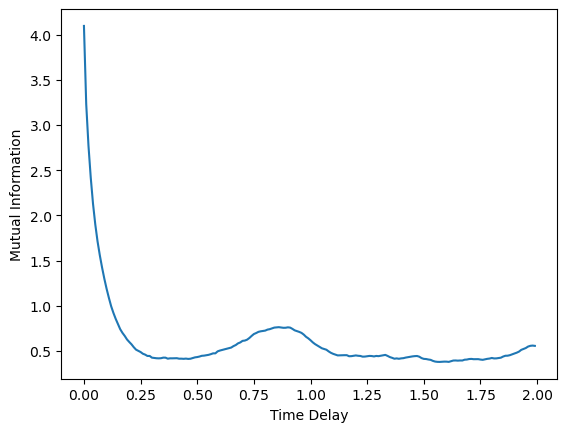

In [26]:

taum=t96[:200]
MIL=np.zeros(200)
for t in range(len(taum)):
    MIL[t]=MIlorenz(taum[t],x96)
for t in range(len(taum)-1):    
  midiff=MIlorenz(taum[t+1],x96)-MIlorenz(taum[t],x96)
  midiff=midiff/h
  if midiff>0:
    
    T96=taum[t]
    break
print("The delay for L96,n=5 map is", T96)
plt.plot(taum,MIL)
plt.xlabel('Time Delay')
plt.ylabel('Mutual Information')
#plt.savefig('img12.jpg')
plt.show()
T96=int(T96*100)

In [27]:
fnn96=np.zeros(10) #taking 2N=10 as max dimensions
for dim in range(1,11):
  col=2000-dim*T96
  m96=np.zeros((dim,col))
  for i in range(col):
    m96[:,i]=np.array([x96[i+j*T96] for j in range(dim)])
    dist=np.linalg.norm(m96-m96[:,i].reshape((dim,1)), axis=0)
    mindist=20000
    for k in range(col):
      if k==i:
        continue
      else:
        if dist[k]<mindist:
          min=k
          mindist=dist[k]
    if np.abs((x96[i+(dim+1)*T96]-x96[min+(dim+1)*T96])/mindist)>rt:
      fnn96[dim-1]+=1
  fnn96[dim-1]=fnn96[dim-1]/(col)*100

[88.00203355 17.68355739  1.10468175  0.16059957  0.          0.
  0.          0.          0.          0.        ]
5


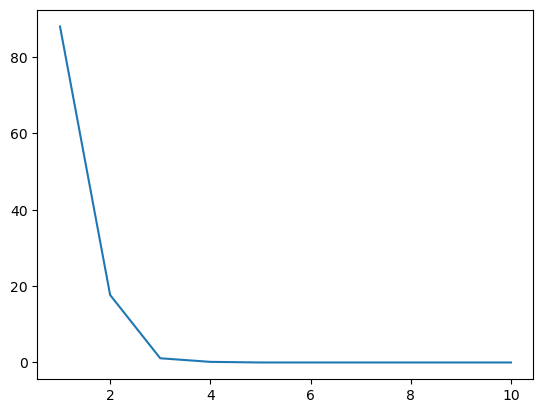

In [28]:
plt.plot(np.arange(1,11),fnn96)
print(fnn96)
for i in range(len(fnn96)):
  if fnn96[i]==0:
    d96=i+1
    print(d96)
    break
plt.show()

In [29]:
indexes = np.arange(0,d96,1)*T96
L96recon5=np.array([x96[indexes +i] for i in range(len(x96)-(d96-1)*T96)])

**Doing the same analysis for n=4**

In [30]:
N=4
x0 = F * np.ones(N)  # Initial state (equilibrium)
x0[0] +=2  # Add small perturbation to the first variable
t96 = np.arange(0.0, 30.0, 0.01)
L96orig = odeint(L96, x0, t96)
x96=L96orig[:,0]
np.shape(L96orig)

(3000, 4)

The delay for L96,n=4 map is 0.16


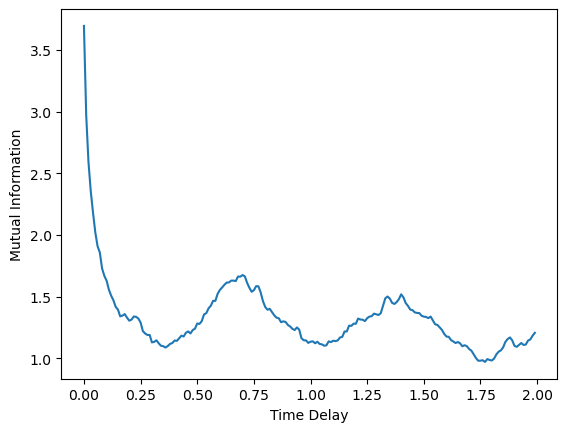

In [31]:
taum=t96[:200]
MIL=np.zeros(200)
for t in range(len(taum)):
    MIL[t]=MIlorenz(taum[t],x96)
for t in range(len(taum)-1):    
  midiff=MIlorenz(taum[t+1],x96)-MIlorenz(taum[t],x96)
  midiff=midiff/h
  if midiff>0:
    
    T96=taum[t]
    break
print("The delay for L96,n=4 map is", T96)
plt.plot(taum,MIL)
plt.xlabel('Time Delay')
plt.ylabel('Mutual Information')
#plt.savefig('img12.jpg')
plt.show()
T96=int(T96*100)

In [32]:
fnn96=np.zeros(8) #taking 2N=8 as max dimensions
for dim in range(1,9):
  col=2000-dim*T96
  m96=np.zeros((dim,col))
  for i in range(col):
    m96[:,i]=np.array([x96[i+j*T96] for j in range(dim)])
    dist=np.linalg.norm(m96-m96[:,i].reshape((dim,1)), axis=0)
    mindist=20000
    for k in range(col):
      if k==i:
        continue
      else:
        if dist[k]<mindist:
          min=k
          mindist=dist[k]
    if np.abs((x96[i+(dim+1)*T96]-x96[min+(dim+1)*T96])/mindist)>rt:
      fnn96[dim-1]+=1
  fnn96[dim-1]=fnn96[dim-1]/(col)*100

[82.66129032  5.23373984  0.          0.          0.          0.
  0.          0.        ]
3


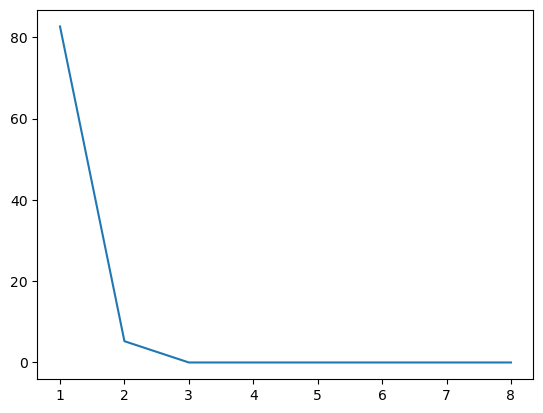

In [33]:
plt.plot(np.arange(1,9),fnn96)
print(fnn96)
for i in range(len(fnn96)):
  if fnn96[i]==0:
    d96=i+1
    print(d96)
    break
plt.show()

**Same analysis for N=6**

In [34]:
N=6
x0 = F * np.ones(N)  # Initial state (equilibrium)
x0[0] +=2  # Add small perturbation to the first variable
t96 = np.arange(0.0, 40.0, 0.01)
L96orig = odeint(L96, x0, t96)
x96=L96orig[:,0]
np.shape(L96orig)

(4000, 6)

The delay for L96,n=6 map is 0.3


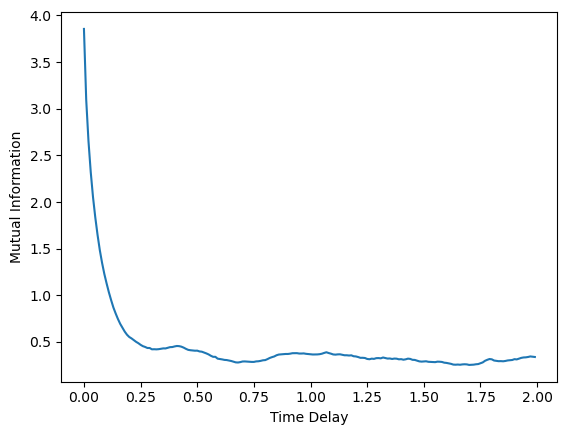

In [35]:
taum=t96[:200]
MIL=np.zeros(200)
for t in range(len(taum)):
    MIL[t]=MIlorenz(taum[t],x96)
for t in range(len(taum)-1):    
  midiff=MIlorenz(taum[t+1],x96)-MIlorenz(taum[t],x96)
  midiff=midiff/h
  if midiff>0:
    T96=taum[t]
    break
print("The delay for L96,n=6 map is", T96)
plt.plot(taum,MIL)
plt.xlabel('Time Delay')
plt.ylabel('Mutual Information')
#plt.savefig('img12.jpg')
plt.show()
T96=int(T96*100)

In [36]:
fnn96=np.zeros(12) #taking 2N=12 as max dimensions
for dim in range(1,11):
  col=2000-dim*T96
  m96=np.zeros((dim,col))
  for i in range(col):
    m96[:,i]=np.array([x96[i+j*T96] for j in range(dim)])
    dist=np.linalg.norm(m96-m96[:,i].reshape((dim,1)), axis=0)
    mindist=20000
    for k in range(col):
      if k==i:
        continue
      else:
        if dist[k]<mindist:
          min=k
          mindist=dist[k]
    if np.abs((x96[i+(dim+1)*T96]-x96[min+(dim+1)*T96])/mindist)>rt:
      fnn96[dim-1]+=1
  fnn96[dim-1]=fnn96[dim-1]/(col)*100

[8.88324873e+01 1.94329897e+01 1.15183246e+00 5.31914894e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
5


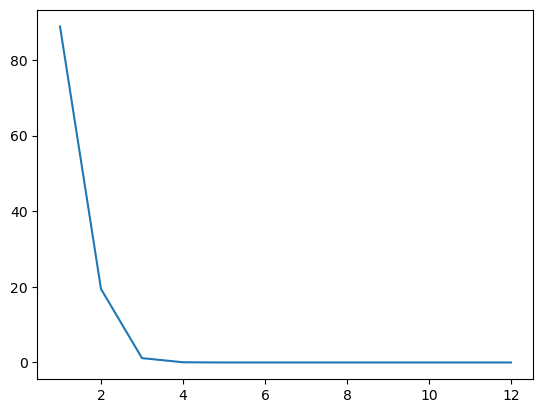

In [37]:
plt.plot(np.arange(1,13),fnn96)
print(fnn96)
for i in range(len(fnn96)):
  if fnn96[i]==0:
    d96=i+1
    print(d96)
    break
plt.show()